# Breakpoint tests

Starting with a known stucture.

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import warnings

In [3]:
from regime_switching.generate.arx import VARXGenerator

In [4]:
import statsmodels.api as sm

## 1-dim AR models

### Create two different random AR models

With the given parameters, the second has only 2 AR lags and more variance.

In [5]:
gen1 = VARXGenerator.random_model(n=1, m=0, p_max=3, p_portion=1, random_state=12)
display(gen1.coef_ar_df)
display(gen1.covariance)

,,0
lag,,
1,0,0.300609
2,0,-0.478138
3,0,0.878121


,0
0,0.202381


In [6]:
gen2 = VARXGenerator.random_model(n=1, m=0, p_max=2, p_portion=1, random_state=14)
display(gen2.coef_ar_df)
display(gen2.covariance)

,,0
lag,,
1,0,0.805642
2,0,-0.487930


,0
0,0.876855


Generate two series, one "full" and one with a structural break

In [7]:
break_T = 70

In [8]:
y1 = gen1.generate(100)[0]
y2_end = gen2.generate(len(y1) - break_T, initial_values=y1.iloc[break_T - len(gen2.coef_ar): break_T])[0]
y2 = pd.concat([y1.iloc[:break_T], y2_end], axis='rows').reset_index(drop=True)

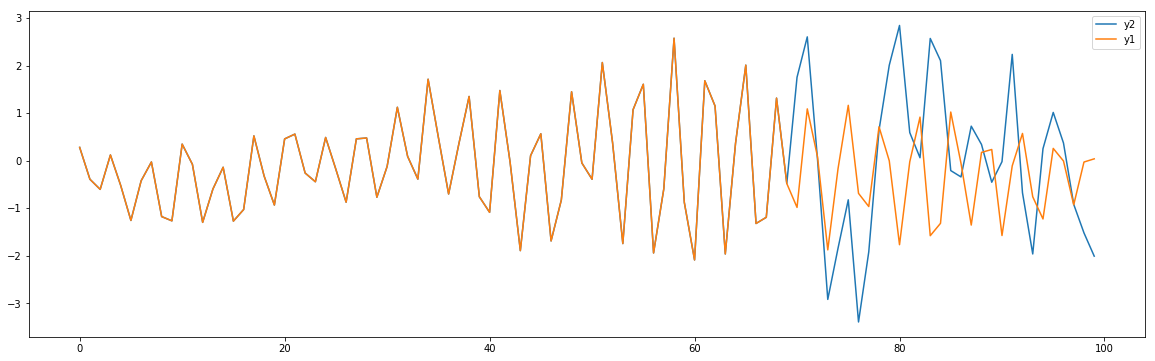

In [9]:
data = pd.DataFrame({
    'y2': y2,
    'y1': y1,
})
data.plot(figsize=(20, 6));

### Detect break

Fit AR models, check log likelihood

In [10]:
m1_full = sm.tsa.AR(y1).fit(maxlag=3)
m1_full.llf

-43.79577468727525

In [11]:
m1_a = sm.tsa.AR(y1.iloc[:break_T]).fit(maxlag=3)
m1_b = sm.tsa.AR(y1.iloc[break_T:]).fit(maxlag=3)
m1_a.llf, m1_b.llf

(-32.2023743171722, -2.397613262192211)

In [12]:
m2_a = sm.tsa.AR(y2.iloc[:break_T]).fit(maxlag=3)
m2_b = sm.tsa.AR(y2.iloc[break_T:]).fit(maxlag=3)
m2_a.llf, m2_b.llf

(-32.2023743171722, -43.43347113652517)

In [13]:
pd.concat([m2_a.params, m2_b.params], axis='columns')

,0,1
const,-0.032557,-0.090953
L1.y,0.351536,0.815747
L2.y,-0.492542,-0.612765
L3.y,0.884519,0.362545


#### Fit models iteratively, switching over at time T, and select the most likely pair

In [14]:
joint_llfs = []
lla = []
llb = []
# idx = pd.RangeIndex(20, 80)
idx = pd.RangeIndex(10, 90)
for T in idx:
    m2_aT = sm.tsa.AR(y2.iloc[:T]).fit(maxlag=3)
    m2_bT = sm.tsa.AR(y2.iloc[T:]).fit(maxlag=3)  # technically this should be 2
    lla.append(m2_aT.llf)
    llb.append(m2_bT.llf)
    joint_llfs.append(m2_aT.llf + m2_bT.llf)
llfs = pd.DataFrame({'joint':joint_llfs, 'a': lla, 'b': llb}, idx)

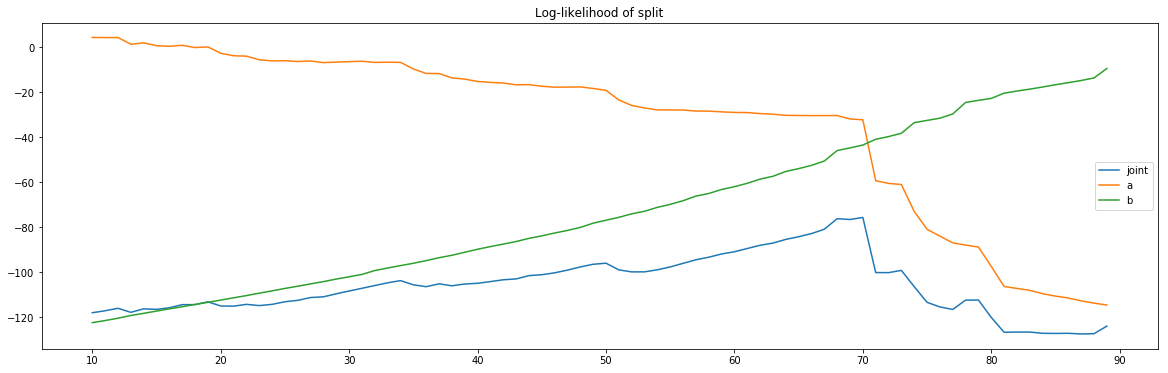

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(20, 6))
ax.set_title('Log-likelihood of split')
llfs.plot(ax=ax);

In [16]:
llfs['joint'].idxmax()

70

In [17]:
break_T

70

We hit the target directly. :)

## 2-d (VAR) models with a break

In [18]:
var1 = VARXGenerator.random_model(n=2, m=0, p_max=3, p_portion=1, random_state=12)
display(var1.coef_ar_df)
display(var1.covariance)

0         1
lag                      
1   0  0.652201 -0.258925
    1  0.646841 -0.468785
2   0 -0.297185 -0.325590
    1 -0.035154  0.507179
3   0  0.206845  0.724252
    1 -0.065620  0.599689

,0,1
0,0.935261,0.895872
1,0.895872,1.047353


In [19]:
var2 = VARXGenerator.random_model(n=2, m=0, p_max=3, p_portion=1, random_state=15)
display(var2.coef_ar_df)
display(var2.covariance)

0         1
lag                      
1   0  0.046493  0.434528
    1  0.464087  0.129973
2   0  0.104864  0.085630
    1  0.109284 -0.380501
3   0 -0.414753 -0.382504
    1  0.543517 -0.456262

,0,1
0,0.416891,0.365040
1,0.365040,0.953831


In [20]:
break_T = 70

z1 = var1.generate(100)
z2_end = var2.generate(len(z1) - break_T, initial_values=z1.iloc[break_T - len(var2.coef_ar): break_T])
z2 = pd.concat([z1.iloc[:break_T], z2_end], axis='rows').reset_index(drop=True)

Both series are stationary:

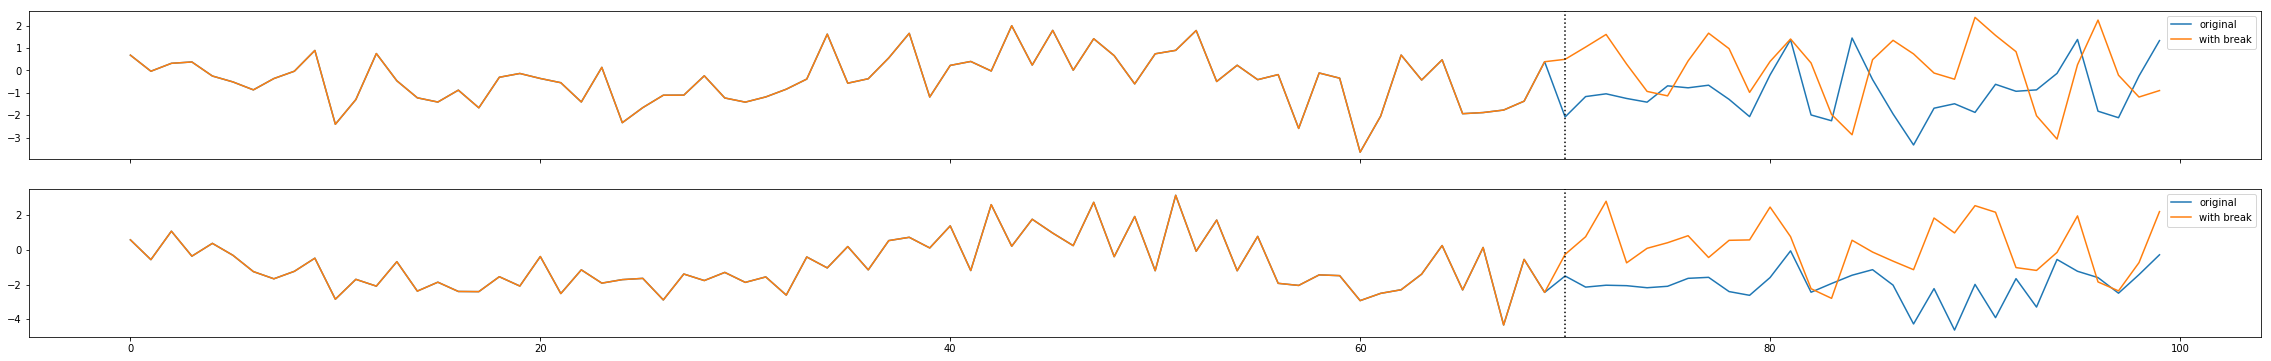

In [21]:
_N = len(var1.endogenous)
fig, ax = plt.subplots(_N, 1, sharex=True, figsize=(20*_N, 6))
for i, v in enumerate(var1.endogenous.values):
    pd.DataFrame({
        'original': z1[v],
        'with break': z2[v],
    }).plot(ax=ax[i])
    ax[i].axvline(break_T, color='black', linestyle=':')
fig;

Coefficients per regime:

In [22]:
r = pd.concat([var1.coef_ar_df, var2.coef_ar_df], axis='columns')
v = pd.concat([var1.covariance, var2.covariance], axis='columns')

r.columns = v.columns = pd.MultiIndex.from_tuples([('v1', 0), ('v1', 1), ('v2', 0), ('v2', 1)])
print("VAR Parameters")
display(r)
print("Covariance")
display(v)

VAR Parameters


v1                  v2          
              0         1         0         1
lag                                          
1   0  0.652201 -0.258925  0.046493  0.434528
    1  0.646841 -0.468785  0.464087  0.129973
2   0 -0.297185 -0.325590  0.104864  0.085630
    1 -0.035154  0.507179  0.109284 -0.380501
3   0  0.206845  0.724252 -0.414753 -0.382504
    1 -0.065620  0.599689  0.543517 -0.456262

Covariance


v1                  v2          
          0         1         0         1
0  0.935261  0.895872  0.416891  0.365040
1  0.895872  1.047353  0.365040  0.953831

### Estimate break point via maximum joint loglihood:

In [23]:
joint_llfs = []
lla = []
llb = []
# idx = pd.RangeIndex(20, 80)
idx = pd.RangeIndex(20, 80)
for T in idx:
    m2_aT = sm.tsa.VAR(z2.iloc[:T]).fit(maxlags=3)
    m2_bT = sm.tsa.VAR(z2.iloc[T:]).fit(maxlags=3)  # technically this should be 2
    lla.append(m2_aT.llf)
    llb.append(m2_bT.llf)
    joint_llfs.append(m2_aT.llf + m2_bT.llf)
llfs = pd.DataFrame({'joint':joint_llfs, 'a': lla, 'b': llb}, idx)

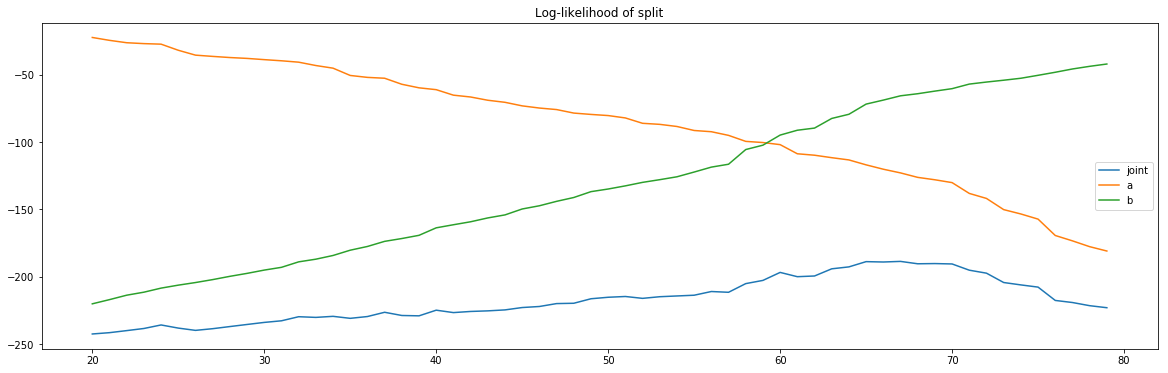

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(20, 6))
ax.set_title('Log-likelihood of split')
llfs.plot(ax=ax);

In [25]:
llfs['joint'].idxmax()

67

In [26]:
break_T

70

Fairly close to the joint split, though not exact.

# Try again with existing function

In [27]:
from regime_switching.fit.single_break import max_joint_likelihood, fit_ar, fit_var

In [28]:
iy, df_y, _ = max_joint_likelihood(y2, fit_ar(3), buffer=10)

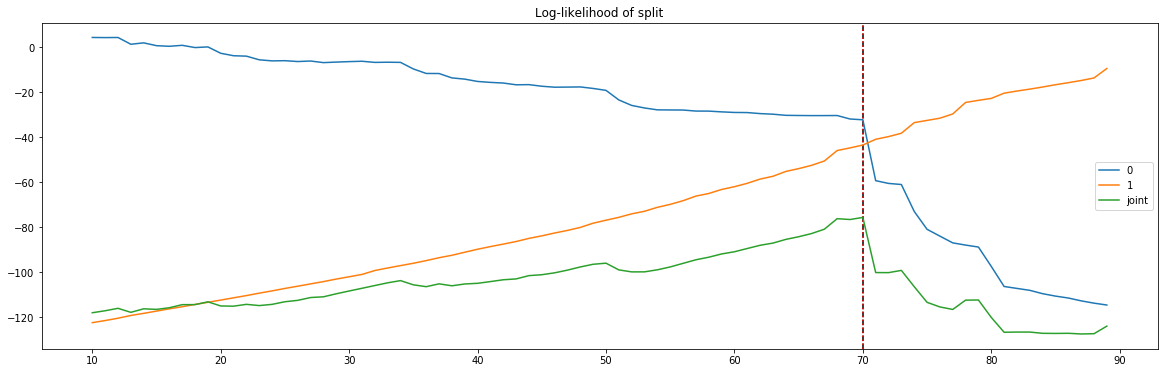

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(20, 6))
ax.set_title('Log-likelihood of split, AR model')
ax.axvline(break_T, color='black', linestyle='--')
ax.axvline(iy, color='red', linestyle=':')
df_y.plot(ax=ax);

In [32]:
iz, df_z, _ = max_joint_likelihood(z2, fit_var(3), buffer=15)

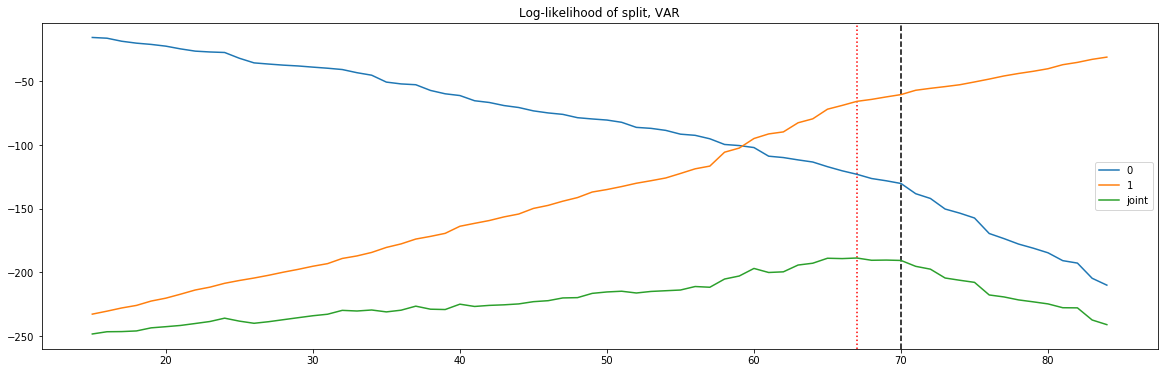

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(20, 6))
ax.set_title('Log-likelihood of split, VAR model')
ax.axvline(break_T, color='black', linestyle='--')
ax.axvline(iz, color='red', linestyle=':')
df_z.plot(ax=ax);